# Blind Source Separation for Decomposing X-ray Pulsar Profiles: Introducing Phase Correlated Variability Analysis (PCVA)
## An analysis example of simulated data

This notebook provides an end-to-end analysis of simulated data of the Phase Correlated Variability Analysis (PCVA). The steps for real data are largely the same, any differences will be explained in the text as well as the code. The structure of the notbook is as follows:

---
### TOC:
* [Simulating a Phase Matrix](#simululation)
    * [Simulating Signals](#signals)
    * [Simulating Weights](#weights)
    * [Creating the Phase Matrix](#matrix)
* [Decompositing the Simulated Phase Matrix into Weights](#decomposition)
* [Rescaling / Optimizing the Weights based on Correlation Information](#rescaling)
* [Visualizing the Results](#visualizing)
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyLCSIM

First, we define some auxiliary functions that will be used later in the project. These consist of normalization and rescaling functions, the computation of correlation matrices, and a convenience function for displaying the results.

In [2]:
def normalise_weights(w1, w2):
    """ Normalises two arrays so that their sum is 1.

    Args:
        w1 (array of floats): weight 1
        w2 (array of floats): weight 2

    Returns:
        arrays: normalised weights 1 and 2 as well as the not normalised sum (pulse profile) of the input components
    """

    wsum = w1 + w2
    w1 = w1 / wsum
    w2 = w2 / wsum
    wsum /= np.mean(wsum)
    return w1, w2, wsum


def rescale(x, a, b): 
    """ Rescales an array between a minimum and maximum value (a and b respectively).
    
    Args:
        x (array): array to be rescaled
        a (float): minimum value
        b (float): maximum value
    
    Returns:
        array: rescaled version of the input array x
    """
    return (b-a)*(x-min(x))/(max(x)-min(x))+a


def cmat(inmat: np.ndarray) -> np.ndarray:
    """ Calculate the correlation matrix of the input matrix.

    inmat is usually a phase matrix (n pulses x m phase bins) and the correlation matrix calculates the correlation of light curves in different phase bins

    Args:
        inmat (numpy.ndarray): input matrix

    Returns:
        comat: correlation matrix
    """

    comat = np.corrcoef(inmat)
    np.fill_diagonal(comat, np.nan)
    return comat


def plot_decomposition(weight1, weight2, profile, ls='solid'):
    """ Convenience function for plotting the results.
    
    Args:
        weight1 (array): single-pole pulse profile 1
        weight2 (array): single-pole pulse profile 2
        profile (array): total pulse profile
        ls (str, optional): line style. Defaults to 'solid'.
    """
    
    plt.plot(np.linspace(0, 1, 32), weight1*profile/np.max(profile), c='#2EB086', lw=1.5, ls=ls)
    plt.plot(np.linspace(0, 1, 32), weight2*profile/np.max(profile), c='#313552', lw=1.5, ls=ls)
    plt.plot(np.linspace(0, 1, 32), profile/np.max(profile), c='#B8425F', lw=1.5, ls=ls)

## Simulating a Phase Matrix <a class="anchor" id="simulation"></a>
### Simulating Signals <a class="anchor" id="signals"></a>
The aim of the simulations is to test whether the PCVA can successfully recover known weights from mixed data. To simulate such a scenario and obtain a phase matrix (i.e. phase-resolved pulse-to-pulse light curves), the signals corresponding roughly to the mass accretion rates at the two poles must be simulated. We do this using the *pyLCSIM* module with parameters typical for X-ray pulsars:

In [3]:
def simulate_signals(npulses=1000, nbins=32, period=1, src=100, bkg=0.1*100, frms=0.1):
    """ Simulates two signal arrays/light curves from broken power laws.

    Args:
        npulses (int, optional): number of pulses to be simulated
        nbins (int, optional): number of phase bins
        period (int, optional): spin period, used for the breaking frequency. Defaults to 1.
        src (int, optional): average source counts. Defaults to 100.
        bkg (float, optional): average background counts. Defaults to 0.1*100.
        frms (float, optional): fractional rms. Defaults to 0.1.

    Returns:
        arrays: two signal arrays / light curves
    """
    
    dt = period / nbins
    
    sim = pyLCSIM.Simulation()
    sim.addModel('smoothbknpo', [1, 1, 2, 1/period])  # normalization, 1st and 2nd power law indices, break freq
    sim.run(dt, npulses, src, rms=frms)
    sim.poissonRandomize(1, bkg)
    _, sig1 = sim.getLightCurve()

    sim2 = pyLCSIM.Simulation()
    sim2.addModel('smoothbknpo', [1, 1, 2, 1/period])
    sim2.run(dt, npulses, src, rms=frms)
    sim2.poissonRandomize(1, bkg)
    _, sig2 = sim2.getLightCurve()

    return sig1, sig2

signal1, signal2 = simulate_signals(npulses=10000)

### Simulating Weights <a class="anchor" id="weights"></a>

In addition, the weights or single-pole pulse profiles must be simulated. These are based on a smoothed sum of six random Gaussians each to mimic real pulse profiles:

In [4]:
input_weight1 = [0.27642342, 0.28182143, 0.28111762, 0.26555583, 0.23413492, 0.19572194,
                 0.16393136, 0.15137984, 0.16843553, 0.22236778, 0.31555893, 0.44232211,
                 0.58699877, 0.72751683, 0.84499924, 0.93295721, 0.99680759, 1.04212852,
                 1.06231091, 1.03873573, 0.95515081, 0.81455964, 0.64427364, 0.48400474,
                 0.36531445, 0.29765795, 0.26990062, 0.26245651, 0.25983832, 0.25677572,
                 0.25615171, 0.2617638]
input_weight2 = [0.73888651, 0.74850594, 0.77530828, 0.82331631, 0.89691266, 1.00227107,
                 1.14138374, 1.30279625, 1.46078114, 1.58379859, 1.64557737, 1.63443513,
                 1.55707999, 1.43507772, 1.29528469, 1.15882863, 1.03451197, 0.92016629,
                 0.81049849, 0.70581674, 0.61581032, 0.55631866, 0.54175321, 0.57804021,
                 0.65949757, 0.76988888, 0.88592593, 0.98174618, 1.03304304, 1.02654174,
                 0.96628741, 0.86986181]

input_weight1, input_weight2, input_profile = normalise_weights(np.array(input_weight1), np.array(input_weight2))

These then are the weights that should be recovered by the PCVA (blue and green, the sum of these would be the total 'observed' pulse profile in red):

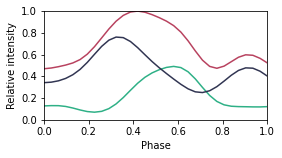

In [5]:
plt.figure(figsize=(4,2))

plot_decomposition(input_weight1, input_weight2, input_profile)

plt.xlabel('Phase')
plt.ylabel('Relative intensity')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

### Creating the Phase Matrix  <a class="anchor" id="matrix"></a>

Now that we have simulated both weights and signals, we can proceed by multiplying them and obtaining the phase matrix, as well as the corresponding correlation matrix, which calculates the correlation degree of light curves in different phase bins:

In [6]:
def simulate_phase_matrix(s1, s2, w1, w2, sw, src=100, poisson=True):
    """ Creates the simulated phase matrix by multiplying the signal and weight matrices.

    Args:
        s1 (array): signal 1 (tracer of the accretion rate onto pole 1)
        s2 (array): signal 2 (tracer of the accretion rate onto pole 2)
        w1 (array): normalised weight 1 (single-pole pulse profile)
        w2 (array): normalised weight 2 (single-pole pulse profile)
        sw (array): not normalised sum of weights 1 and 2 (pulse profile)
        src (int, optional): mean (source) counts. Defaults to 100.

    Returns:
        numpy.ndarray: simulated phase matrix
    """

    AR, SR = np.array((w1, w2)).T, np.array((s1, s2))
    simat  = np.dot(AR, SR)
    simat  = simat / np.mean(simat) * src
    simat  = (simat.T*sw).T
    if poisson:
        simat  = simat / np.mean(simat) * src
        simat  = np.random.poisson(simat)
    return simat


phase_matrix = simulate_phase_matrix(signal1, signal2, input_weight1, input_weight2, input_profile)

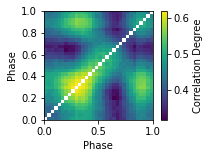

In [7]:
plt.figure(figsize=(3,2))
im = plt.imshow(cmat(phase_matrix), aspect='equal', extent=(0,1,0,1), origin='lower')
plt.xlabel('Phase')
plt.ylabel('Phase')
cbar = plt.colorbar(im)
cbar.set_label('Correlation Degree')
plt.show()

As can be seen, the correlation matrix shows distinct patterns and varying degrees of correlation as the simulated neutron star rotates. When analyzing a real observation, the phase matrix can be constructed from a light curve by extracting phase-resolved pulse-to-pulse light curves. The correlation matrix can then be calculated in the same way as shown above.

### Decomposition <a class="anchor" id="decomposition"></a>
The simulated phase matrix can then be decomposed using a blind source separation algorithm. We have chosen to use the sklearn.decomposition NMF (Non-Negative Matrix Factorisation) function, but in principle other algorithms such as Principal Component Analysis (PCA), Independent Component Analysis (ICA), etc. can also be used.

In [8]:
def decompose(inmat):
    """ Decomposition of an input matrix into two components using the NMF method.

    inmat is usually a phase matrix (n pulses x m phase bins)
    output arrays have a size of n phase bins

    Args:
        inmat (numpy.ndarray): input phase matrix matrix

    Returns:
        arrays: decomposition results, d1 and d2
    """
  
    from sklearn.decomposition import NMF
    inmat     = inmat if (np.shape(inmat)[0] < np.shape(inmat)[1]) else inmat.T
    meaninmat = np.mean(inmat, axis=-1)

    # The following parameters may need to be adjusted depending on the source being analysed to ensure convergence, these parameters are specifically adjusted for Cen X-3 and its simulations:
    model = NMF(n_components=2, 
                init='random', 
                max_iter=int(1e6), 
                solver='mu', 
                tol=1e-10
                )
    
    fit_t   = model.fit_transform(inmat)
    weights = fit_t.T
    
    d1 = meaninmat * weights[0] / (weights[0] + weights[1])
    d2 = meaninmat - d1

    if np.argmax(d1) > np.argmax(d2):
        d1, d2 = d1, d2
    else:
        d1, d2 = d2, d1

    return d1, d2


decomposed_weight1, decomposed_weight2 = decompose(phase_matrix)
decomposed_weight1, decomposed_weight2, decomposed_weights_sum = normalise_weights(decomposed_weight1, decomposed_weight2)

We can now examine the outcomes of the decomposition in comparison to our initial input. Additionally, generating a new phase matrix using these newly decomposed weights and examining the corresponding correlatio matrix can provide insight into the success of the decomposition: 

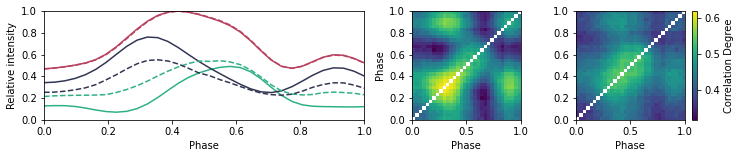

In [9]:
plt.figure(figsize=(12,2))

ax0 = plt.subplot(1,4,(1,2))

ax0.plot(np.linspace(0, 1, 32), input_weight1*input_profile/np.max(input_profile), c='#2EB086', lw=1.5, ls='solid')
ax0.plot(np.linspace(0, 1, 32), input_weight2*input_profile/np.max(input_profile), c='#313552', lw=1.5, ls='solid')
ax0.plot(np.linspace(0, 1, 32), input_profile/np.max(input_profile), c='#B8425F', lw=1.5, ls='solid')
ax0.plot(np.linspace(0, 1, 32), decomposed_weight1*decomposed_weights_sum/np.max(decomposed_weights_sum), c='#2EB086', lw=1.5, ls='dashed')
ax0.plot(np.linspace(0, 1, 32), decomposed_weight2*decomposed_weights_sum/np.max(decomposed_weights_sum), c='#313552', lw=1.5, ls='dashed')
ax0.plot(np.linspace(0, 1, 32), decomposed_weights_sum/np.max(decomposed_weights_sum), c='#B8425F', lw=1.5, ls='dashed')

ax0.set_xlabel('Phase')
ax0.set_ylabel('Relative intensity')
ax0.set_ylim(0, 1)
ax0.set_xlim(0, 1)

ax1 = plt.subplot(143)
ax1.imshow(cmat(phase_matrix), 
           aspect='equal', 
           extent=(0,1,0,1), 
           origin='lower', 
           vmin=np.nanmin((cmat(phase_matrix), cmat(simulate_phase_matrix(signal1, signal2, decomposed_weight1, decomposed_weight2, decomposed_weights_sum)))), 
           vmax=np.nanmax((cmat(phase_matrix), cmat(simulate_phase_matrix(signal1, signal2, decomposed_weight1, decomposed_weight2, decomposed_weights_sum)))))
ax2 = plt.subplot(144)
im = ax2.imshow(cmat(simulate_phase_matrix(signal1, signal2, decomposed_weight1, decomposed_weight2, decomposed_weights_sum)), 
           aspect='equal', 
           extent=(0,1,0,1), 
           origin='lower', 
           vmin=np.nanmin((cmat(phase_matrix), cmat(simulate_phase_matrix(signal1, signal2, decomposed_weight1, decomposed_weight2, decomposed_weights_sum)))), 
           vmax=np.nanmax((cmat(phase_matrix), cmat(simulate_phase_matrix(signal1, signal2, decomposed_weight1, decomposed_weight2, decomposed_weights_sum)))))
cbar = plt.colorbar(im)
cbar.set_label('Correlation Degree')
ax1.set_xlabel('Phase')
ax1.set_ylabel('Phase')
ax2.set_xlabel('Phase')
plt.show()

It can be seen that the weights are recovered only in shape, rather than scaling. This is reflected in the flatter correlation matrix that appears less distinct. However, by using this information, we can optimise the scaling. To achieve this, we can rescale the weights, calculate a new phase matrix, determine the correlation matrix, and compare it with the initial correlation matrix. This will help us to find the scaling that best reflects the correlation properties. Below are the exact steps explaining the process.

### Rescaling / Optimization <a class="anchor" id="rescaling"></a>

The optimization is performed using the correlation matrices as a measure. We have implemented a Particle Swarm Optimisation (PSO) to find the optimal solution. The parameters that are optimized are the min-max rescaling values. Note that this is done on normalized versions of the decomposition result. This ensures numerical stability and also ensures that all dimensions have a similar scale, preventing one dimension from dominating the optimization. This leads to faster convergence and more effective exploration of the search space. 

In [10]:
def scale_weights(p1, p2, obsmat, sig1, sig2):
    """ Optimise and scale the weights 

    Args:
        p1 (array): weight 1
        p2 (array): weight 2
        obsmat (ndarray): observed phase matrix

    Returns:
        arrays: scaled weights
    """
    import pyswarms as ps
    
    def optimisation(x):
        """ Cost function to optimise the scaling of the decompositions by minimising the difference of observed and simulated correlation matrix.

        Args:
            p (list of floats): minimum and maximum values for rescaling

        Returns:
            float: mean of sum of squared differences (SSD) between correlation matrices
        """        
        p1opt     = rescale(p1, x[0][0], x[0][1])
        p2opt     = 1.0 - p1opt
        
        ff        = []
        for _ in range(10):  # 10 iterations to ensure robustness, can be modified if needed
            optmat      = simulate_phase_matrix(sig1, sig2, p1opt, p2opt, pp, src=np.mean(obsmat))
            cmat_xtopt  = cmat(optmat)
            cmat_xt     = cmat(obsmat)
                        
            ff.append(np.nansum((cmat_xt-cmat_xtopt)**2))
            
        return np.median(ff)

    pp        = np.mean(obsmat, 1) / np.mean(np.mean(obsmat, 1))
    optimiser = ps.single.GlobalBestPSO(n_particles=100, 
                                        dimensions=2, 
                                        options={'c1': 0.2, 'c2': 0.2, 'w':0.8}, 
                                        bounds=(np.array([0.0, 0.5]), np.array([0.5, 1.0])))
    _, k      = optimiser.optimize(optimisation, iters=50)

    p1scaled  = rescale(p1, k[0], k[1])
    p2scaled  = (p1+p2)-p1scaled
    
    p1scaled  = p1scaled*input_profile
    p2scaled  = p2scaled*input_profile

    return p1scaled, p2scaled


optimized_weight1, optimized_weight2 = scale_weights(decomposed_weight1, decomposed_weight2, phase_matrix, signal1, signal2)
optimized_weight1, optimized_weight2, optimized_weights_sum = normalise_weights(optimized_weight1, optimized_weight2)

2023-10-13 10:22:57,748 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.2, 'c2': 0.2, 'w': 0.8}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.126
2023-10-13 10:23:12,787 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.12595988243514303, best pos: [0.10532302 0.61000255]


The result of this optimization can now be visualized in a new correlation matrix and the result is much closer to the original correlation matrix. Note that the parameters of the PSO can be adjusted to ensure more robust convergence. For this example, we have instead chosen parameters for faster termination.

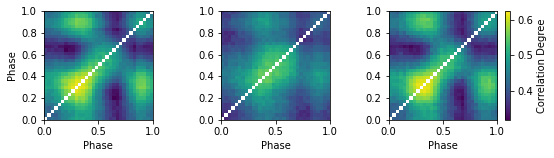

In [11]:
plt.figure(figsize=(9,2))
ax0 = plt.subplot(131)
ax0.imshow(cmat(phase_matrix), 
           aspect='equal', 
           extent=(0,1,0,1), 
           origin='lower', 
           vmin=np.nanmin((cmat(phase_matrix), cmat(simulate_phase_matrix(signal1, signal2, optimized_weight1, optimized_weight2, optimized_weights_sum)))), 
           vmax=np.nanmax((cmat(phase_matrix), cmat(simulate_phase_matrix(signal1, signal2, optimized_weight1, optimized_weight2, optimized_weights_sum)))))
ax1 = plt.subplot(132)
ax1.imshow(cmat(simulate_phase_matrix(signal1, signal2, decomposed_weight1, decomposed_weight2, decomposed_weights_sum)), 
           aspect='equal', 
           extent=(0,1,0,1), 
           origin='lower', 
           vmin=np.nanmin((cmat(phase_matrix), cmat(simulate_phase_matrix(signal1, signal2, decomposed_weight1, decomposed_weight2, decomposed_weights_sum)))), 
           vmax=np.nanmax((cmat(phase_matrix), cmat(simulate_phase_matrix(signal1, signal2, decomposed_weight1, decomposed_weight2, decomposed_weights_sum)))))
ax2 = plt.subplot(133)
im = ax2.imshow(cmat(simulate_phase_matrix(signal1, signal2, optimized_weight1, optimized_weight2, optimized_weights_sum)), 
           aspect='equal', 
           extent=(0,1,0,1), 
           origin='lower', 
           vmin=np.nanmin((cmat(phase_matrix), cmat(simulate_phase_matrix(signal1, signal2, optimized_weight1, optimized_weight2, optimized_weights_sum)))), 
           vmax=np.nanmax((cmat(phase_matrix), cmat(simulate_phase_matrix(signal1, signal2, optimized_weight1, optimized_weight2, optimized_weights_sum)))))
cbar = plt.colorbar(im)
cbar.set_label('Correlation Degree')
ax0.set_xlabel('Phase')
ax0.set_ylabel('Phase')
ax1.set_xlabel('Phase')
ax2.set_xlabel('Phase')
plt.show()

### Visualizing the Results <a class="anchor" id="visualizing"></a>
Finally, we can visualise the simulated weights, the initial decomposition and the optimised weights. (Note that the optimisation by rescaling is performed using normalised versions of the input, and is therefore not a direct scaling of the input components).

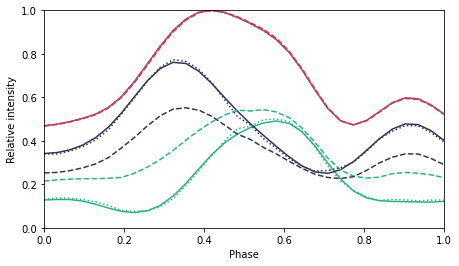

In [12]:
plt.figure(figsize=(7.16535, 4))

plot_decomposition(input_weight1, input_weight2, input_profile)
plot_decomposition(decomposed_weight1, decomposed_weight2, decomposed_weights_sum, ls='dashed')
plot_decomposition(optimized_weight1, optimized_weight2, optimized_weights_sum, ls='dotted')

plt.xlabel('Phase')
plt.ylabel('Relative intensity')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()